#### Imports

# Water Classifier Net for Satellite Images

## EECE2410. Computing Fundamentals for Engineers

### Author: Laura T. Tomarossi Teixeira, Fall 2024

This program follows PEP8 formatting standards and includes extensive annotations designed to guide users and readers through the process of building a binary classification CNN framework. Functions are written with type hints for clarity and precision.



In [2]:
try:
    # System
    import os
    from pathlib import Path

    # Common
    from tqdm import tqdm
    import random
    import shutil

    # Data
    import numpy as np
    from PIL import Image, ImageOps, ImageEnhance

    # Viz
    %matplotlib inline
    import matplotlib.pyplot as plt

    # ML
    os.environ["KERAS_BACKEND"] = "tensorflow"

    import keras
    from keras import preprocessing
    from keras import models
    from keras import layers
    from keras import optimizers
    from keras import utils
    from keras import callbacks

    print("All imports successfully loaded.")

except ImportError as e:
    print(f"Import error: {e}")

except Exception as e:
    print(f"An unexpected error occurred: {e}")


All imports successfully loaded.


### Set Up Bases for Datasets
[!] Important Note: the user must change the base_path below, to the folder that the "Water Bodies Dataset" is located in.

In [31]:

# Base path
base_path = Path(r'C:\Users\17818\Desktop\Academics\EECE2140')

# For pre-processing block
dataset_folder = base_path.joinpath('Water Bodies Dataset')

# For segmentation block
output_folder = base_path.joinpath('Processed_Data')
segmented_folder = base_path.joinpath('Segmented_Data_Set')
model_dir = base_path.joinpath('models')

# training 
train_dir = segmented_folder.joinpath('train')
val_dir = segmented_folder.joinpath('val')
test_dir = segmented_folder.joinpath('test')

input_shape = (256, 256, 3)

# Dictionary of paths
paths = {
    "Base Path": base_path,
    "Dataset Folder": dataset_folder,
    "Output Folder": output_folder,
    "Segmented Folder": segmented_folder,
    "Train Directory": train_dir,
    "Validation Directory": val_dir,
    "Test Directory": test_dir,
    "Model Directory": model_dir
}

# Loop to check directories and create them if they don't exist
print("Directories and their status:\n")
for name, path in paths.items():
    if not path.exists():
        path.mkdir(parents=True, exist_ok=True)  # Create the directory and parent directories if needed
        print(f"{name}: {path} -> Created")
    else:
        print(f"{name}: {path} -> Already Exists")


Directories and their status:

Base Path: C:\Users\17818\Desktop\Academics\EECE2140 -> Already Exists
Dataset Folder: C:\Users\17818\Desktop\Academics\EECE2140\Water Bodies Dataset -> Already Exists
Output Folder: C:\Users\17818\Desktop\Academics\EECE2140\Processed_Data -> Already Exists
Segmented Folder: C:\Users\17818\Desktop\Academics\EECE2140\Segmented_Data_Set -> Already Exists
Train Directory: C:\Users\17818\Desktop\Academics\EECE2140\Segmented_Data_Set\train -> Already Exists
Validation Directory: C:\Users\17818\Desktop\Academics\EECE2140\Segmented_Data_Set\val -> Already Exists
Test Directory: C:\Users\17818\Desktop\Academics\EECE2140\Segmented_Data_Set\test -> Already Exists
Model Directory: C:\Users\17818\Desktop\Academics\EECE2140\models -> Created


### 1:  Load and Pre-Process the Data

Data Augmentation and Data Sample Display functions are nested in the Data-Loader function, so they are established first here.

In [ ]:
def apply_augmentation(image: Image, mask: Image):
    # Data Augmentation: technique used to amplify dataset size by applying variations
    # and increased "error". In this function, three augmentations are applied:
    # Mirroring, Brightness, and Contrast manipulation.
    
    image = image.resize((256, 256), Image.BILINEAR)
    mask = mask.resize((256, 256), Image.NEAREST)
    x = 0.4  # Probability factor. (1 - x) chance of applying the random adjustments.
    
    # This operation mirrors the image to augment image orientation variety.
    if np.random.rand() > x:
        image = ImageOps.mirror(image)
        mask = ImageOps.mirror(mask)

    # This operation changes image brightness to augment image lighting variety.
    if np.random.rand() > x:
        enhancer = ImageEnhance.Brightness(image)
        image = enhancer.enhance(np.random.uniform(0.8, 1.2))  # Range: 80% to 120% brightness

    # This operation changes contrast settings to augment image variety.
    if np.random.rand() > x:
        enhancer = ImageEnhance.Contrast(image)
        image = enhancer.enhance(np.random.uniform(0.8, 1.2))  # Range: 80% to 120% contrast

    return image, mask


##### Pre-Processing Block

display_data_sample called
Loaded 10 images and 10 masks.


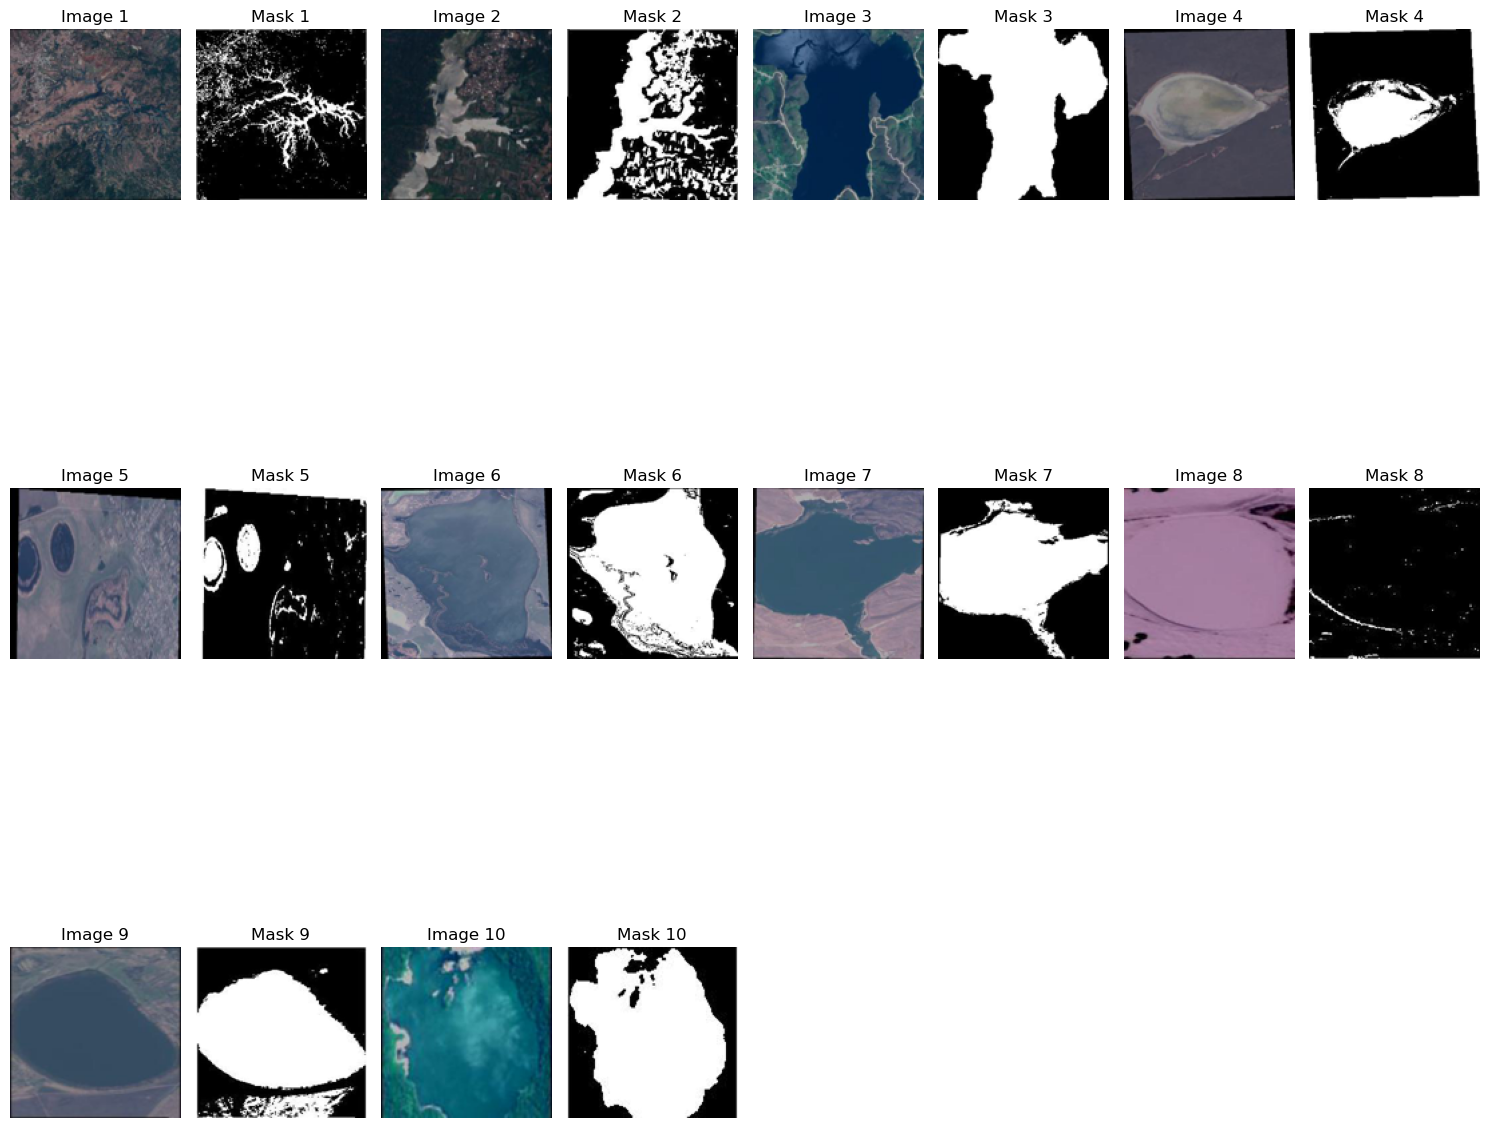

In [24]:

def display_data_sample(output_folder, N):
    print("display_data_sample called")

    # Ensure output_folder is a Path object
    output_folder = Path(output_folder)

    # Define directories
    image_dir = output_folder.joinpath("Images")
    mask_dir = output_folder.joinpath("Masks")

    # Sort and load the image-mask sets
    image_files = sorted(
        [file for file in os.listdir(image_dir) if file.endswith(".jpg")])[:N]
    mask_files = sorted(
        [file for file in os.listdir(mask_dir) if file.endswith(".jpg")])[:N]

    # Load the image-mask sets
    resize_size = (128, 128)  # Make them smaller for display
    images = [
        np.array(Image.open(image_dir.joinpath(file)).resize(resize_size))
        for file in image_files
    ]
    masks = [
        np.array(Image.open(mask_dir.joinpath(file)).resize(resize_size))
        for file in mask_files
    ]

    # Print for debugging purposes
    print(f"Loaded {len(images)} images and {len(masks)} masks.")

    # Plotting
    images_per_row = 3  # Number of images per row
    rows = (N + images_per_row - 1) // images_per_row  # Ceiling division
    plt.figure(figsize=(15, 5 * rows))  # Adjust the figure size dynamically
    for i in range(N):
        # Display the image
        plt.subplot(rows, images_per_row * 2, 2 * i + 1)
        plt.imshow(images[i])
        plt.title(f"Image {i + 1}")
        plt.axis("off")

        # Display the mask
        plt.subplot(rows, images_per_row * 2, 2 * i + 2)
        plt.imshow(masks[i], cmap="gray")
        plt.title(f"Mask {i + 1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [7]:
def load_and_organize_data(dataset_folder, output_folder, augment=True):
    # Ensure the input is a Path object (makes it better for processing)
    dataset_folder = Path(dataset_folder)
    output_folder = Path(output_folder)

    # Define the paths for the input images and masks
    image_folder = dataset_folder.joinpath("Images")
    mask_folder = dataset_folder.joinpath("Masks")
    os.makedirs(output_folder.joinpath("Images"), exist_ok=True)
    os.makedirs(output_folder.joinpath("Masks"), exist_ok=True)

    # Verify directories exist (for troubleshooting purposes)
    if not dataset_folder.exists():
        raise FileNotFoundError(
            f"The dataset folder '{dataset_folder}' does not exist."
        )
    if not image_folder.exists():
        raise FileNotFoundError(
            f"The Images folder '{image_folder}' does not exist."
        )
    if not mask_folder.exists():
        raise FileNotFoundError(
            f"The Masks folder '{mask_folder}' does not exist."
        )

    # Retrieve and sort the list of image and mask files to match them
    image_files = sorted(
        [file for file in os.listdir(image_folder) if file.endswith(".jpg")]
    )
    mask_files = sorted(
        [file for file in os.listdir(mask_folder) if file.endswith(".jpg")]
    )

    # Check if there are files in both directories (for troubleshooting purposes)
    if not image_files:
        raise FileNotFoundError(f"No image files found in '{image_folder}'.")
    if not mask_files:
        raise FileNotFoundError(f"No mask files found in '{mask_folder}'.")

    # Process each image-mask pair with a progress bar for feedback
    for image_file, mask_file in tqdm(
        zip(image_files, mask_files),
        total=len(image_files),
        desc="Processing pairs"
    ):
        image_path = image_folder.joinpath(image_file)
        mask_path = mask_folder.joinpath(mask_file)
        result_image_path = output_folder.joinpath("Images", image_file)
        result_mask_path = output_folder.joinpath("Masks", mask_file)

        try:
            # Open the images and masks - converting images to RGB and masks to grayscale
            image = Image.open(image_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")

            # Apply data augmentation if enabled
            if augment:
                image, mask = apply_augmentation(image, mask)

            # Save the processed image and mask to the output folder
            image.save(result_image_path)
            mask.save(result_mask_path)

        except Exception as e:
            print(f"Error processing {image_file} and {mask_file}: {e}")

    # Display the total number of processed images
    print(f"Processed {len(image_files)} images in '{output_folder}'.")


In [ ]:

load_and_organize_data(dataset_folder, output_folder)




Processing pairs: 100%|████████████████████████████████████████████████████████████| 2841/2841 [03:34<00:00, 13.25it/s]

Processed 2841 images in 'C:\Users\17818\Desktop\Academics\EECE2140\Processed_Data'.


In [ ]:
segment_dataset(
    output_folder.joinpath('Images'), 
    output_folder.joinpath('Masks'), 
    segmented_folder
)


### 2: Data Segmentation Module

In [ ]:
def segment_dataset(
    images_dir: Path,
    masks_dir: Path,
    output_dir: Path,
    train_ratio: float = 0.7,
    val_ratio: float = 0.15,
    test_ratio: float = 0.15,
):
    # The dataset ratios are specified above
    os.makedirs(output_dir, exist_ok=True)

    # Link the image-mask pairs together and shuffle them
    combined = list(
        zip(
            sorted(os.listdir(images_dir)),
            sorted(os.listdir(masks_dir))
        )
    )
    random.shuffle(combined)

    # Calculate dataset split indices
    num_images = len(combined)
    train_end = int(train_ratio * num_images)
    val_end = train_end + int(val_ratio * num_images)

    # Define the data splits
    splits = {
        "train": combined[:train_end],
        "val": combined[train_end:val_end],
        "test": combined[val_end:],
    }

    # Copy each image-mask pair to the respective train/val/test folders
    for split, files in splits.items():
        for image_file, mask_file in tqdm(files, desc=f"Processing {split} set"):
            shutil.copy(
                str(images_dir.joinpath(image_file)),
                str(output_dir.joinpath(split, "images")),
            )
            shutil.copy(
                str(masks_dir.joinpath(mask_file)),
                str(output_dir.joinpath(split, "masks")),
            )

    print("Dataset segmented into train, validation, and test folders.")


### 3: CNN Architecture Module

In [25]:
def build_model(input_shape: keras.KerasTensor, optimizer: optimizers.Optimizer = optimizers.AdamW()):

    # Initialize a Sequential model, which is a linear stack of layers
    model = models.Sequential([
        layers.InputLayer(input_shape),
        # Conv2D applies 32 filters to the input image, each of size 3x3
        # the activation function ReLU (Rectified Linear Unit) helps the network learn non-linear patterns
        layers.Conv2D(32, (3, 3), activation='relu'),
        
        # MaxPooling2D reduces the spatial size of the feature maps by only taking the extremum within each 2x2 region, aka downsampling
        layers.MaxPooling2D((2, 2)),

        # adds more filters to learn slightly more complex patterns and features from the data
        layers.Conv2D(64, (3, 3), activation='relu'),
        
        # performs downsampling again
        layers.MaxPooling2D((2, 2)),

        # adds even more filters (128) to capture complex patterns in the image
        layers.Conv2D(128, (3, 3), activation='relu'),
        
        # downsamples again - captures higher-level features
        layers.MaxPooling2D((2, 2)),

        # FlattenConverts the 2D feature map into a 1D vector to prepare for fully connected layers
        # This is necessary because the following Dense layers work with 1D data
        layers.Flatten(),

        # dense is a fully connected layer with 128 neurons, where each neuron is connected to all the neurons in the previous layer
        # ReLU activation is used here to add non-linearity, enabling the model to learn complex patterns
        layers.Dense(128, activation='relu'),

        # output layer
        # dense is a single output neuron with a sigmoid activation function, producing a value between 0 and 1
        # this single value tells us the probability that the image belongs to the target class- aka, whether water is present
        layers.Dense(1, activation='sigmoid')  # sigmoid activation is ideal for binary classification
    ])
    
    
    # build and compile the model: configure the optimizer, loss function, eval metrics
    
    model.compile( 
        optimizer=optimizer, # adam's great and 0.001 is recommended
        loss="binary_crossentropy", # binary output
        metrics=["accuracy"] # accuracy is our priority metric during training
    )
        

    return model

AttributeError: module 'keras' has no attribute 'KerasTensor'

### Training Module

In [ ]:
def train_model(
    train_dir: Path | str,
    val_dir: Path | str,
    input_shape: tuple[int, int, int] = (256, 256, 3),
    batch_size: int = 32,
    epochs: int = 10,
    optimizer: optimizers.Optimizer = optimizers.AdamW,
    **kwargs,
):
    # The shape, batch size, and epochs are specified above.

    # Set up data generators to load and preprocess images for training and validation.
    # ImageDataGenerator is a Keras class that enables real-time data augmentation and scaling.

    train_data_loader = utils.image_dataset_from_directory(
        train_dir,
        label_mode="binary",
        image_size=input_shape[:2],
        batch_size=batch_size,
    )
    val_data_loader = utils.image_dataset_from_directory(
        val_dir,
        label_mode="binary",
        image_size=input_shape[:2],
        batch_size=batch_size,
    )

    # Build the CNN model
    model = build_model(input_shape, optimizer=optimizer)

    # Set up a checkpoint callback to save the best model based on validation loss.
    # ModelCheckpoint saves the model with the best performance (lowest validation loss).
    checkpoint = callbacks.ModelCheckpoint(
        "best_model.keras", monitor="val_loss", save_best_only=True, mode="min"
    )

    # Train the model using the training data generator.
    # The fit method trains the model for a specified number of epochs
    # and evaluates it using the validation data.
    history = model.fit(
        train_data_loader,          # Data generator for training images.
        validation_data=val_data_loader,  # Data generator for validation images.
        epochs=epochs,              # Number of epochs to train the model.
        callbacks=[checkpoint],     # Saves the best-performing model during training.
        **kwargs,
    )

    # Return the trained model and the training history.
    return model, history


### Test Model

In [ ]:
# Call the training model to give us our model and history

# Training parameters
batch_size = 20
epochs = 10
lr = 0.001
optimizer = optimizers.AdamW(learning_rate=lr)
lrs = callbacks.ReduceLROnPlateau(factor=0.1, patience=3)

model, history = train_model(
    train_dir=train_dir,
    val_dir=val_dir,
    input_shape=input_shape,
    batch_size=batch_size,
    epochs=epochs,
    optimizer=optimizer,
    callbacks=[lrs],
)


In [34]:
saved_model: keras.Model = keras.models.load_model("best_model.keras")

test_data_loader = utils.image_dataset_from_directory(test_dir, label_mode='binary', image_size=input_shape[:2], batch_size=1)

# Eval the first image we get

saved_model.evaluate(test_data_loader)



TypeError: Error when deserializing class 'InputLayer' using config={'batch_shape': [None, 256, 256, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}.

Exception encountered: Unrecognized keyword arguments: ['batch_shape']